In [1]:
from tqdm.auto import tqdm

/home/igu/miniconda3/envs/ml_2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from models.madlib import MadlibModel

In [3]:
import pandas as pd

## Setting up the Model

In [4]:
import torch

if torch.cuda.is_available():
    print("CUDA is available! PyTorch can use the GPU.")
    # You can also get more info about the GPU
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"Current GPU device name: {torch.cuda.get_device_name(0)}") # 0 is the index of the first GPU
else:
    print("CUDA is NOT available. PyTorch will run on CPU.")

CUDA is available! PyTorch can use the GPU.
Number of GPUs available: 1
Current GPU device name: NVIDIA GeForce RTX 4060 Ti


In [5]:
epsilon = 5

In [6]:
model = MadlibModel(num_labels=2, epsilon=epsilon)
tokenizer = model.tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MadlibModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): NoisyEmbedding(
          (embedding): Embedding(30522, 384, padding_idx=0)
        )
        (position_embeddings): Embedding(512, 384)
        (token_type_embeddings): Embedding(2, 384)
        (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-5): 6 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (d

In [7]:
embedding_matrix = model.original_emb.weight  # Shape: (vocab_size, hidden_size)

## Setting up the Data

In [8]:
def collect_token_embeddings_in_batches(model, tokenizer, device, batch_size=32, num_repeats=1000):
    model.eval()
    token_ids = sorted(list(tokenizer.get_vocab().values()))
    idx = []
    embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(token_ids), batch_size), desc="Collecting token embeddings"):
            batch_token_ids = token_ids[i:i+batch_size]

            # Create input tensor: each token ID repeated `num_repeats` times
            input_ids = torch.tensor(batch_token_ids, dtype=torch.long, device=device)  # (batch_size,)
            input_ids = input_ids.repeat_interleave(num_repeats).view(-1, 1)  # (batch_size * num_repeats, 1)

            # Get embeddings: (batch_size * num_repeats, 1, hidden_dim)
            token_embeds = model.get_embeddings(input_ids).squeeze(1).cpu()  # (batch_size * num_repeats, hidden_dim)

            # Split back per token
            for j, token_id in enumerate(batch_token_ids):
                start = j * num_repeats
                end = start + num_repeats
                idx.append(token_id)
                embeddings.append(token_embeds[start:end])  # (num_repeats, hidden_dim)

    return idx, embeddings

idx, embeddings = collect_token_embeddings_in_batches(
    model, tokenizer, device,
    batch_size=512,
    num_repeats=1000
)

## To each token, find the other token in embedding_matrix that is closer

In [9]:
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm

def compute_closest_embeddings(idx_list, embedding_list, embedding_matrix, tokenizer, batch_size=1024):
    """
    Computes the most similar tokens (from a reference embedding matrix) for a list of token embeddings.

    Args:
        idx_list (list[int]): List of token IDs (flat list).
        embedding_list (list[Tensor]): List of token embedding tensors (one per token).
        embedding_matrix (Tensor): Tensor of shape (V, D) with reference embeddings.
        tokenizer: HuggingFace tokenizer.
        batch_size (int): Batch size for processing.

    Returns:
        pd.DataFrame: DataFrame with columns:
            - token_id
            - closest_token_id
            - similarity
            - token
            - closest_token
    """
    device = embedding_matrix.device
    embedding_matrix_norm = F.normalize(embedding_matrix, p=2, dim=1)  # (V, D)

    # Validate input lengths
    assert len(idx_list) == len(embedding_list), "Mismatch between idx_list and embedding_list lengths"

    # Prepare containers
    all_closest_token_ids = []
    all_similarities = []

    num_tokens = len(idx_list)
    
    for batch_start in tqdm(range(0, num_tokens, batch_size), desc="Processing token batches"):
        batch_end = min(batch_start + batch_size, num_tokens)

        batch_embeddings = embedding_list[batch_start:batch_end]

        # Stack and normalize embeddings
        stacked_embeddings = torch.stack(batch_embeddings).to(device)  # (batch_size, D)
        emb_norm = F.normalize(stacked_embeddings, p=2, dim=1)         # (batch_size, D)

        # Compute cosine similarity: (batch_size, D) × (D, V)ᵗ = (batch_size, V)
        similarities = torch.matmul(emb_norm, embedding_matrix_norm.T)

        # Find the most similar token in the vocab
        closest_similarities, closest_indices = torch.max(similarities, dim=2)

        # Store results
        all_closest_token_ids.extend(closest_indices.cpu().tolist())
        all_similarities.extend(closest_similarities.cpu().tolist())

    # Create DataFrame
    df_results = pd.DataFrame({
        "token_id": idx_list,
        "closest_token_id": all_closest_token_ids,
        "similarity": all_similarities
    })

    # Add string representations
    df_results["token"] = tokenizer.convert_ids_to_tokens(df_results["token_id"])
    df_results["closest_token"] = [tokenizer.convert_ids_to_tokens(x) for x in df_results["closest_token_id"]]

    df_results["closest_token"]

    return df_results


In [10]:
import faiss

def compute_closest_embeddings_faiss(idx_list, embedding_list, embedding_matrix, tokenizer, batch_size=1024):
    """
    Computes the most similar tokens (from a reference embedding matrix) for a list of token embeddings using FAISS on GPU.

    Args:
        idx_list (list[int]): List of token IDs.
        embedding_list (list[Tensor]): List of token embedding tensors (one per token).
        embedding_matrix (Tensor): Tensor of shape (V, D) with reference embeddings.
        tokenizer: HuggingFace tokenizer.
        batch_size (int): Batch size for querying.

    Returns:
        pd.DataFrame with:
            - token_id
            - closest_token_id
            - similarity
            - token
            - closest_token
    """
    assert len(idx_list) == len(embedding_list), "idx_list and embedding_list length mismatch"

    # Normalize and convert embedding matrix to NumPy
    embedding_matrix = F.normalize(embedding_matrix, dim=1)
    embedding_dim = embedding_matrix.shape[1]
    embedding_matrix_np = embedding_matrix.cpu().detach().numpy()

    # Always use GPU
    res = faiss.StandardGpuResources()
    index_flat = faiss.IndexFlatIP(embedding_dim)
    index = faiss.index_cpu_to_gpu(res, 0, index_flat)
    index.add(embedding_matrix_np)

    all_closest_token_ids = []
    all_similarities = []

    # Process in batches
    for batch_start in tqdm(range(0, len(idx_list), batch_size), desc="FAISS search"):
        batch_end = min(batch_start + batch_size, len(idx_list))
        batch_embeddings = embedding_list[batch_start:batch_end]

        # Stack and normalize
        batch_tensor = torch.stack(batch_embeddings)  # (B, D)
        batch_tensor = F.normalize(batch_tensor, dim=1)

        # batch_tensor shape: (batch_size, 100, embed_size)
        B, N, D = batch_tensor.shape
        batch_tensor_reshaped = batch_tensor.reshape(B * N, D)  # (B*100, embed_size)
        batch_tensor_reshaped = F.normalize(batch_tensor_reshaped, dim=1)  # normalize all vectors

        batch_tensor_np = batch_tensor_reshaped.cpu().detach().numpy()

        indices,similarities  = index.search(batch_tensor_np, k=1)  # now shape (B*100, 1)

        # reshape back if needed
        similarities = similarities.reshape(B, N)
        indices = indices.reshape(B, N)


        all_closest_token_ids.extend(similarities.tolist())
        all_similarities.extend(indices.tolist())

    # Create DataFrame
    df_results = pd.DataFrame({
        "token_id": idx_list,
        "closest_token_id": all_closest_token_ids,
        "similarity": all_similarities
    })
    # Add token strings
    df_results["token"] = tokenizer.convert_ids_to_tokens(df_results["token_id"])
    df_results["closest_token"] = [tokenizer.convert_ids_to_tokens(x) for x in df_results["closest_token_id"]]

    return df_results

In [11]:
df_results = compute_closest_embeddings_faiss(
    idx_list=idx,
    embedding_list=embeddings,
    embedding_matrix=embedding_matrix,
    tokenizer=tokenizer,
    batch_size=64
)

FAISS search: 100%|██████████| 477/477 [02:05<00:00,  3.79it/s]


In [12]:
df_results["nw"] = df_results.apply(lambda row: row["closest_token_id"].count(row["token_id"]), axis=1)
df_results["sw"] = df_results["closest_token_id"].apply(lambda x: len(set(x)))

In [13]:
df_results["sw"].value_counts()

sw
982    2960
983    2944
981    2778
984    2761
985    2471
980    2415
979    2072
986    2043
978    1704
987    1665
977    1168
988    1145
976     927
989     779
975     655
990     457
974     452
973     254
991     250
972     166
992     119
971      96
970      71
993      63
969      33
968      26
967      22
994      17
965       3
964       2
966       2
996       1
997       1
Name: count, dtype: int64

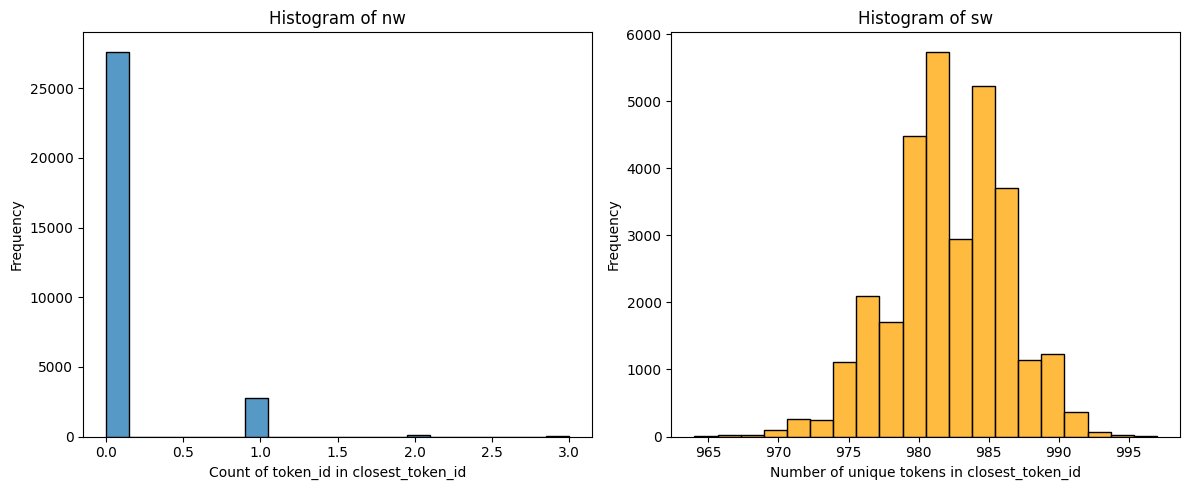

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot histograms
plt.figure(figsize=(12, 5))

# Plot nw
plt.subplot(1, 2, 1)
sns.histplot(df_results["nw"], bins=20, kde=False)
plt.title("Histogram of nw")
plt.xlabel("Count of token_id in closest_token_id")
plt.ylabel("Frequency")

# Plot sw
plt.subplot(1, 2, 2)
sns.histplot(df_results["sw"], bins=20, kde=False, color="orange")
plt.title("Histogram of sw")
plt.xlabel("Number of unique tokens in closest_token_id")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

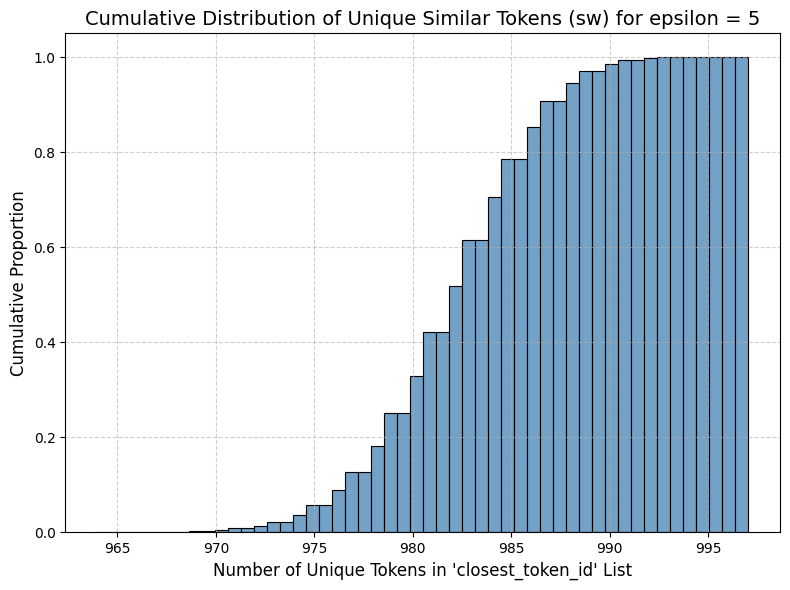

In [15]:
# Set up plot
plt.figure(figsize=(8, 6))
sns.histplot(
    df_results["sw"],
    bins=50,
    cumulative=True,
    stat="density",
    kde=False,
    color="steelblue"
)

# Human-readable labels
plt.title(f"Cumulative Distribution of Unique Similar Tokens (sw) for epsilon = {epsilon}", fontsize=14)
plt.xlabel("Number of Unique Tokens in 'closest_token_id' List", fontsize=12)
plt.ylabel("Cumulative Proportion", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(f"figs/cumulative_sw_madlib_{epsilon}.pdf")
plt.show()

In [16]:
import os

file_path = f"data/closest_tokens_madlib_epsilon{epsilon}.csv"

if os.path.exists(file_path):
    # Append without header
    df_results.to_csv(file_path, mode='a', header=False, index=False)
else:
    # Write with header
    df_results.to_csv(file_path, index=False)
